In [1]:
# I wanted to separate ARIMA code from Bloom.ipynb but did not have the time. File is 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
%%capture
# create loading bar
from tqdm.notebook import tqdm
tqdm().pandas()

In [3]:
count_ig_csv = 'emerging_risks_doc_count_instagram.csv'
count_tw_csv = 'emerging_risks_doc_count_twitter.csv'
engagement_fb_csv = 'emerging_risks_local_engagement_facebook.csv'
engagement_ig_csv = 'emerging_risks_local_engagement_instagram.csv'
engagement_tw_csv = 'emerging_risks_local_engagement_twitter.csv'
files = [count_ig_csv, count_tw_csv, engagement_fb_csv, engagement_ig_csv, engagement_tw_csv]

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
df = pd.read_csv(engagement_tw_csv)
df.date = pd.to_datetime(df.date)

In [8]:
df.set_index(df.date, inplace=True)

In [9]:
topic = df.Pesticides[:-3]

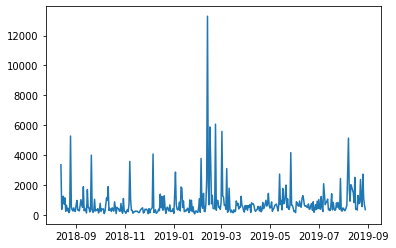

In [10]:
plt.plot(topic)
plt.show()

In [11]:
result = adfuller(topic)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.1872894280195423
p-value: 0.02073230677695242
Critical Values:
	1%: -3.448493650810824
	5%: -2.8695352280356556
	10%: -2.5710293341377715


Figure(432x288)


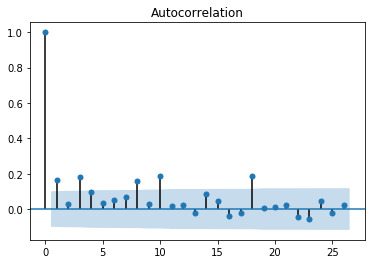

In [13]:
# get MA term
p_acf = plot_acf(topic) # significant at 1, 3, 8, 10, 18.
print(p_acf)            # otherwise create 2 plots

Figure(432x288)


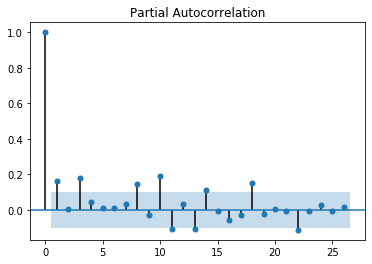

In [14]:
# get AR terms
p_pacf = plot_pacf(topic) # significant at 1, 3, 8, 10, 14, 18
print(p_pacf)

In [53]:
ARIMA_model = ARIMA(topic, order=(1, 0, 1)).fit()

In [54]:
# statsmodels ARIMA gets negative values when setting I >= 1. I try to differentiate first and then set I = 0.

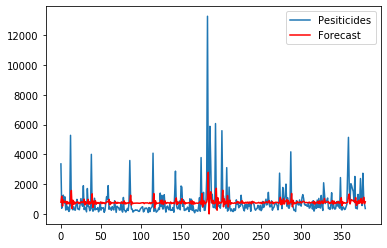

In [55]:
plt.plot(topic, label="Pesiticides")
plt.plot(ARIMA_model.fittedvalues, color='red', label="Forecast")
plt.legend(loc='best')
plt.show()

In [57]:
mean_absolute_percentage_error(topic, ARIMA_model.fittedvalues)

115.62287831997766

In [58]:
mean_squared_error(topic, ARIMA_model.fittedvalues)

1128723.9330124364

In [59]:
print(ARIMA_model.summary())

                              ARMA Model Results                              
Dep. Variable:             Pesticides   No. Observations:                  381
Model:                     ARMA(1, 1)   Log Likelihood               -3195.463
Method:                       css-mle   S.D. of innovations           1062.148
Date:                Sat, 11 Apr 2020   AIC                           6398.926
Time:                        20:34:51   BIC                           6414.698
Sample:                             0   HQIC                          6405.184
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              783.0225     61.491     12.734      0.000     662.502     903.543
ar.L1.Pesticides    -0.3170      0.197     -1.613      0.107      -0.702       0.068
ma.L1.Pesticides     0.4885 

In [ ]:
sarima_model = SARIMAX(topic, order=(3, 0, 3), seasonal_order=(1, 1, 1, 2))

In [37]:
# drop date because does not allow rolling AND dates are continuous, so removal is not an issue
df_moving_avg = df.drop(columns='date').rolling(7).mean()

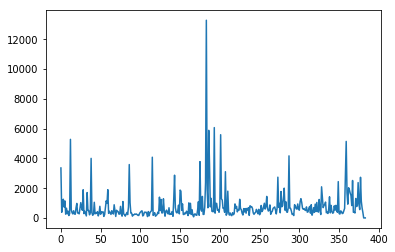

In [39]:
plt.plot(topic)

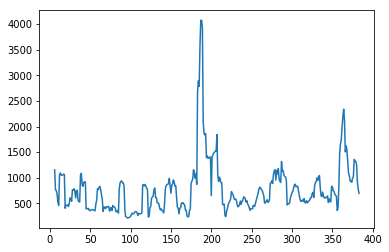

In [40]:
plt.plot(df_moving_avg.Pesticides)

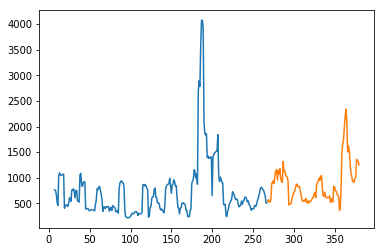

In [41]:
#data = df.Pesticides
data = df.Pesticides[:-3].rolling(7).mean()[7:]  # last 3 values are 0, first 7 values of rolling are NaN
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]
train.plot()
valid.plot()

In [162]:
# auto detect best ARIMA fit
stepwise_fit = pm.auto_arima(topic, start_p=1, start_q=1, max_p=10, max_q=30, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=6271.205, BIC=6290.786, Time=5.615 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=6676.553, BIC=6684.385, Time=0.065 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=6492.463, BIC=6508.128, Time=1.674 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=6272.170, BIC=6287.835, Time=3.286 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=6674.561, BIC=6678.477, Time=0.080 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=6488.540, BIC=6504.204, Time=0.830 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant

In [163]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  384
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -3128.379
Date:                              Thu, 09 Apr 2020   AIC                           6268.758
Time:                                      16:04:17   BIC                           6292.255
Sample:                                           0   HQIC                          6278.090
                                              - 384                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2234      1.119      0.200      0.842      -1.970       2.417
ar.L1         -0.4582      0.197     -2.322      0.020      -0.845      -0.071
ma.L1         -0.3369      0.175     -1.928      0.054      -0.679       0.006
ma.L2         -0.5449      0.176     -3.098      0.002      -0.890      -0.200
ma.S.L12      -0.9990      0.021    -47.211      0.000      -1.040      -0.958
sigma2      1.122e+06   1.36e-07   8.24e+12      0.000    1.12e+06    1.12e+06
===================================================================================
Ljung-Box (Q):                       60.29   Jarque-Bera (JB):             36812.02
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             5.02
Prob(H) (two-sided):                  0.76   Kurtosis:                        50.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+29. Standard errors may be unstable.
"""

In [172]:
automatico = stepwise_fit.predict_in_sample()

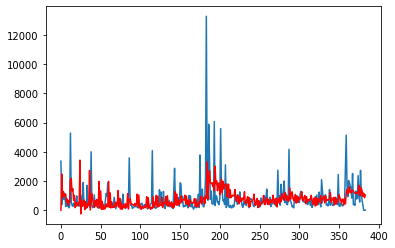

In [173]:
plt.plot(topic)
plt.plot(automatico, color='red')

In [176]:
mean_absolute_percentage_error(topic[:-3], automatico[:-3])

112.78308226359366

In [178]:
mean_squared_error(topic, automatico)

1249133.5297497644

In [14]:
def arima_predict(ser: pd.Series, p: int, d: int, q: int, train_size: float = 0.66) -> tuple:
    X = ser.values
    size = int(len(X) * train_size)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit(disp=False) # disp=False means no convergence output
        output = model_fit.forecast()
        yhat = output[0]
        if yhat is None:
            raise ValueError("Hessian could not be inverted and no value could be forecasted.") # maybe try in R?
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print(f'predicted={yhat}, expected={obs}')
    # predictions = [ARIMA(history, order=(p, d, q)).fit(disp=False).forecast()[0] for t in tqdm(range(len(test)))]
    
    return test, predictions

def plot_arima_predict(arima_predict_result: dict, exp=False) -> None:
    """
    :param exp: set to True if you want to exponentiate the solution
    """
    # plot
    if exp:
        test = np.exp(arima_predict_result[0])
        predictions = np.exp(arima_predict_result[1])
    else:
        test = arima_predict_result[0]
        predictions = arima_predict_result[1]
    
    error = mean_squared_error(test, predictions)
    print(f'Test MSE: {error:.3f}')
    
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()


Test MSE: 590485.338


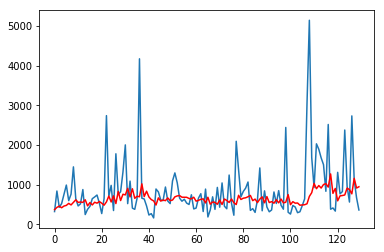

In [15]:
plot_arima_predict(arima_predict(np.log(df.Pesticides[:-3]), 1, 1, 2), exp=True)